In [1]:
import dgl
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
import dgl.nn.pytorch as dglnn
import itertools
from dgl.nn import GraphConv
from dgl.nn import SumPooling
from dgl.nn import DenseGraphConv
from dgl.nn import SAGEConv
import dgl.data

Using backend: pytorch
C:\Users\79776\anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


In [2]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [3]:
class SAGE(nn.Module):
    def __init__(self, in_feats, h_feats, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.h_feats = h_feats
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, h_feats, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(h_feats, h_feats, 'mean'))
        self.layers.append(dglnn.SAGEConv(h_feats, h_feats, 'mean'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, in_feat):
        h = in_feat
        for l,layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [4]:
#for directed graph will be, it will be different 
class DotPredictor(nn.Module): 
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [5]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [6]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


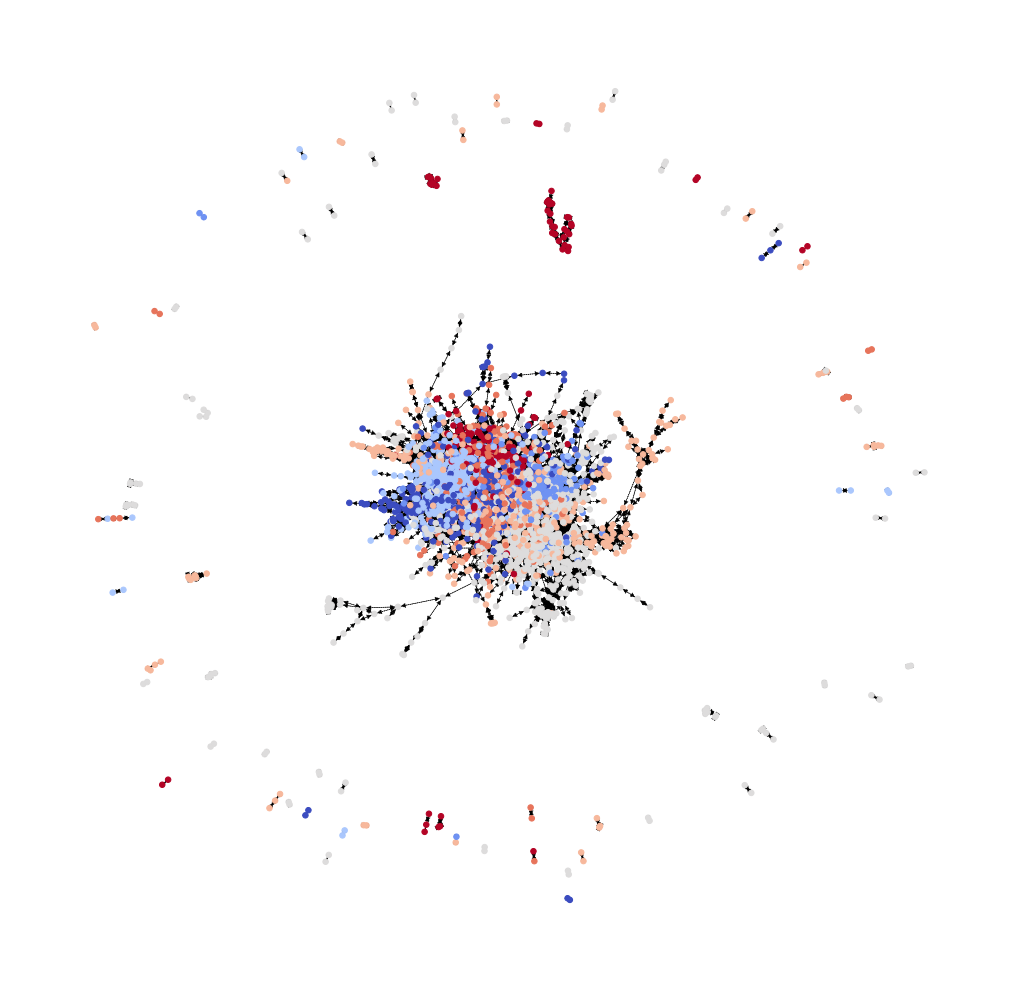

In [7]:
label1 = g.ndata['label']
nx_G1 = g.to_networkx()

def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(18, 18))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=30, cmap=plt.get_cmap('coolwarm'), node_color=labels, 
                     edge_color='k', arrows=True, width=0.7, style='dotted', with_labels=False)
    
visualize(label1, nx_G1)

In [8]:
u, v = g.edges()
print(g.nodes())
print(g.edges())
print(len(u), len(v))

tensor([   0,    1,    2,  ..., 2705, 2706, 2707])
(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]), tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))
10556 10556


In [9]:
#positive sample for test and train 
eids = np.arange(g.number_of_edges())
print(eids, len(eids))
eids = np.random.permutation(eids)
print(eids, len(eids))
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
print(train_size, test_size)
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

[    0     1     2 ... 10553 10554 10555] 10556
[5283  136  309 ... 6515 8345 4333] 10556
9501 1055


In [10]:
a=np.random.permutation([1,2,3, 4, 5]) #example do permutation
for i in a: 
  print(i)

4
1
3
2
5


In [11]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy()))) #it is positive edges
print((u.numpy(), v.numpy()))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes()) #ununderstandable
print('todense=', adj.todense(), len(adj.todense()))
print(adj_neg, adj_neg[0], len(adj_neg))
neg_u, neg_v = np.where(adj_neg != 0)
print('negativ=', neg_u, neg_v)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

(array([   0,    0,    0, ..., 2707, 2707, 2707], dtype=int64), array([ 633, 1862, 2582, ...,  598, 1473, 2706], dtype=int64))
todense= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]] 2708
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]] [[0. 1. 1. ... 1. 1. 1.]] 2708
negativ= [   0    0    0 ... 2707 2707 2707] [   1    2    3 ... 2703 2704 2705]


In [12]:
print(adj)

  (0, 633)	1.0
  (0, 1862)	1.0
  (0, 2582)	1.0
  (1, 2)	1.0
  (1, 652)	1.0
  (1, 654)	1.0
  (2, 1)	1.0
  (2, 1986)	1.0
  (2, 332)	1.0
  (2, 1666)	1.0
  (2, 1454)	1.0
  (3, 2544)	1.0
  (4, 2176)	1.0
  (4, 1016)	1.0
  (4, 1761)	1.0
  (4, 1256)	1.0
  (4, 2175)	1.0
  (5, 1629)	1.0
  (5, 2546)	1.0
  (5, 1659)	1.0
  (6, 1416)	1.0
  (6, 1602)	1.0
  (6, 1042)	1.0
  (6, 373)	1.0
  (7, 208)	1.0
  :	:
  (2694, 431)	1.0
  (2694, 2695)	1.0
  (2695, 431)	1.0
  (2695, 2694)	1.0
  (2696, 2615)	1.0
  (2697, 986)	1.0
  (2698, 1400)	1.0
  (2698, 1573)	1.0
  (2699, 2630)	1.0
  (2700, 1151)	1.0
  (2701, 44)	1.0
  (2701, 2624)	1.0
  (2702, 186)	1.0
  (2702, 1536)	1.0
  (2703, 1298)	1.0
  (2704, 641)	1.0
  (2705, 287)	1.0
  (2706, 165)	1.0
  (2706, 169)	1.0
  (2706, 1473)	1.0
  (2706, 2707)	1.0
  (2707, 165)	1.0
  (2707, 598)	1.0
  (2707, 1473)	1.0
  (2707, 2706)	1.0


In [13]:
train_g = dgl.remove_edges(g, eids[:test_size]) #subgraph
print(train_g)

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


In [14]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
print(train_pos_g)
print(train_neg_g)
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
print(test_pos_g)
print(test_neg_g)

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=2708, num_edges=4223,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=2708, num_edges=1055,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=2708, num_edges=1055,
      ndata_schemes={}
      edata_schemes={})


In [15]:
#model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
model = SAGE(train_g.ndata['feat'].shape[1], 16, 4, F.relu, 0.25)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [16]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.7269834876060486
In epoch 5, loss: 0.6203480362892151
In epoch 10, loss: 0.6113535761833191
In epoch 15, loss: 0.5802364945411682
In epoch 20, loss: 0.5439605116844177
In epoch 25, loss: 0.5168132781982422
In epoch 30, loss: 0.48695138096809387
In epoch 35, loss: 0.453243225812912
In epoch 40, loss: 0.43443775177001953
In epoch 45, loss: 0.411954790353775
In epoch 50, loss: 0.40380534529685974
In epoch 55, loss: 0.3942998945713043
In epoch 60, loss: 0.38139042258262634
In epoch 65, loss: 0.3698093593120575
In epoch 70, loss: 0.3596253991127014
In epoch 75, loss: 0.3508072793483734
In epoch 80, loss: 0.33708569407463074
In epoch 85, loss: 0.33023133873939514
In epoch 90, loss: 0.32861655950546265
In epoch 95, loss: 0.31477659940719604
AUC 0.8578378742615845


In [17]:
print(pred(train_pos_g, h), len(pred(train_pos_g, h)))
print(h, h[0], len(h[0]))
print(min(h[0]), max(h[0]))

tensor([6.3378, 3.0226, 1.7557,  ..., 1.9625, 1.7146, 3.4930],
       grad_fn=<SelectBackward>) 9501
tensor([[-0.0626, -0.0683,  0.4463,  ..., -0.5434, -0.1850, -0.3011],
        [-0.2089, -0.1564,  0.0751,  ..., -0.2600, -0.4516, -0.1837],
        [ 0.0807,  0.1368,  0.4266,  ..., -0.7257, -0.1923, -0.1641],
        ...,
        [ 0.1259, -0.2528,  0.9936,  ..., -0.8095, -0.3187, -0.1622],
        [-0.0792,  0.1463,  0.2443,  ...,  0.3387,  0.2802,  0.2427],
        [ 0.0645,  0.4140,  0.3778,  ..., -0.3488,  0.0311,  0.2124]],
       grad_fn=<AddBackward0>) tensor([-0.0626, -0.0683,  0.4463,  0.2642, -0.2906, -0.0939,  0.1763, -0.2702,
        -0.1648, -0.4324, -0.1224, -0.4744, -0.4076, -0.5434, -0.1850, -0.3011],
       grad_fn=<SelectBackward>) 16
tensor(-0.5434, grad_fn=<SelectBackward>) tensor(0.4463, grad_fn=<SelectBackward>)
